In [24]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.models import load_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf

In [25]:
# Define the folder path where the CSV files are located
folder_path = '/Users/dantashashou/Downloads/euromillions'
# folder_path = r'C:\Users\33766\Desktop\mlipproject\data'

# Use the glob module to find all CSV files in the folder
csv_files = glob.glob(f'{folder_path}/*.csv')

# Define the column names that you want to keep
columns_to_keep = ['annee_numero_de_tirage', 'boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5', 'etoile_1', 'etoile_2']

# Initialize an empty DataFrame to hold data from all files
df = pd.DataFrame()

# Iterate over each CSV file
for file in csv_files:
    # Read the CSV file, only keeping specified columns and setting encoding, separator, and index column parameters
    df_temp = pd.read_csv(file, encoding='ISO-8859-1', sep=';', index_col=False, usecols=columns_to_keep)
    # Append the data to the combined DataFrame
    df = pd.concat([df, df_temp], ignore_index=True)

# Sort the combined DataFrame by 'annee_numero_de_tirage' in ascending order
df.sort_values(by='annee_numero_de_tirage', inplace=True)
# Reset the index of the combined DataFrame
df.reset_index(drop=True, inplace=True)


In [26]:
# 对主球号码进行排序
df.iloc[:, 1:6] = np.sort(df.iloc[:, 1:6].values, axis=1)
# 对星号号码进行排序
df.iloc[:, 6:8] = np.sort(df.iloc[:, 6:8].values, axis=1)

df

,annee_numero_de_tirage,boule_1,boule_2,boule_3,boule_4,boule_5,etoile_1,etoile_2
0,2004001,16,29,32,36,41,7,9
1,2004002,7,13,39,47,50,2,5
2,2004003,14,18,19,31,37,4,5
3,2004004,4,7,33,37,39,1,5
4,2004005,15,24,28,44,47,4,5
...,...,...,...,...,...,...,...,...
1704,20244007,14,23,39,48,50,3,12
1705,20244008,8,19,32,41,42,9,12
1706,20244009,5,10,19,27,30,5,6
1707,20244010,13,20,23,27,42,5,9


# EDA

In [27]:
# 计算基本统计量
stats = df.describe()
print(stats)

       annee_numero_de_tirage      boule_1      boule_2      boule_3  \
count            1.709000e+03  1709.000000  1709.000000  1709.000000   
mean             6.476212e+06     8.478642    16.843768    25.302516   
std              7.833765e+06     6.626029     8.169003     8.679588   
min              2.004001e+06     1.000000     2.000000     5.000000   
25%              2.011068e+06     3.000000    10.000000    19.000000   
50%              2.015096e+06     7.000000    16.000000    25.000000   
75%              2.020001e+06    12.000000    23.000000    32.000000   
max              2.024401e+07    38.000000    44.000000    47.000000   

           boule_4      boule_5     etoile_1     etoile_2  
count  1709.000000  1709.000000  1709.000000  1709.000000  
mean     34.108250    42.606202     3.988882     8.055588  
std       8.381806     6.662664     2.517944     2.556358  
min       9.000000    16.000000     1.000000     2.000000  
25%      28.000000    39.000000     2.000000     6.

#### 检测异常值

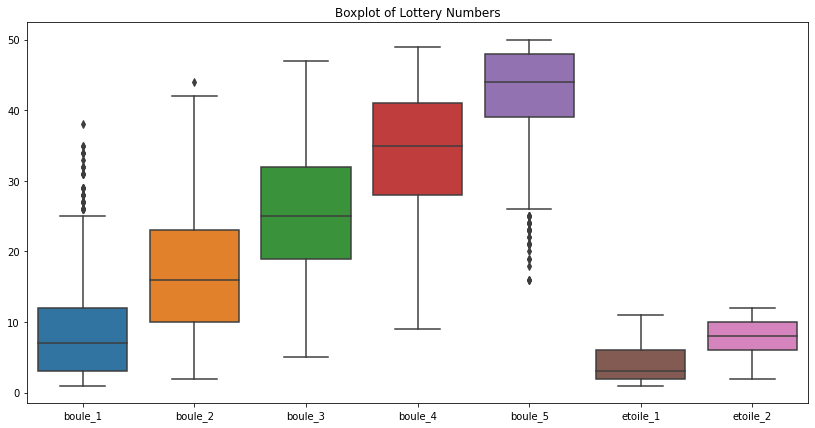

In [28]:
# 使用箱线图来检测每个数字的潜在异常值
plt.figure(figsize=(14, 7))
sns.boxplot(data=df[['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5', 'etoile_1', 'etoile_2']])
plt.title('Boxplot of Lottery Numbers')
plt.show()

#### 每个球号码出现频率

In [29]:
# 分开绘制主球号的频率分布
for i in range(1, 6):  # 对于主球号
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=df[f'boule_{i}'], nbinsx=50, marker_color='blue', name=f'boule_{i}'))
    fig.update_layout(
        title_text=f'Frequency of boule_{i}',
        xaxis_title_text='Number',
        yaxis_title_text='Frequency',
        bargap=0.2,  # 间距
    )
    fig.show()

# 分开绘制星号的频率分布
for i in range(1, 3):  # 对于星号
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=df[f'etoile_{i}'], nbinsx=12, marker_color='red', name=f'etoile_{i}'))
    fig.update_layout(
        title_text=f'Frequency of etoile_{i}',
        xaxis_title_text='Number',
        yaxis_title_text='Frequency',
        bargap=0.2,  # 间距
    )
    fig.show()


#### 主球/星号 号码出现频率

In [30]:
# 合并所有主球号码和星号球号码
main_balls = df[['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5']].values.flatten()
star_balls = df[['etoile_1', 'etoile_2']].values.flatten()

# 绘制主球号码的频率分布
fig_main = go.Figure()
fig_main.add_trace(go.Histogram(x=main_balls, nbinsx=50, marker_color='blue', name='Main Balls'))
fig_main.update_layout(
    title_text='Frequency Distribution of Main Ball Numbers',
    xaxis_title_text='Number',
    yaxis_title_text='Frequency',
    bargap=0.2,  # 间距
)
fig_main.show()

# 绘制星号球号码的频率分布
fig_star = go.Figure()
fig_star.add_trace(go.Histogram(x=star_balls, nbinsx=12, marker_color='red', name='Star Balls'))
fig_star.update_layout(
    title_text='Frequency Distribution of Star Ball Numbers',
    xaxis_title_text='Number',
    yaxis_title_text='Frequency',
    bargap=0.2,  # 间距
)
fig_star.show()

#### 相关性矩阵

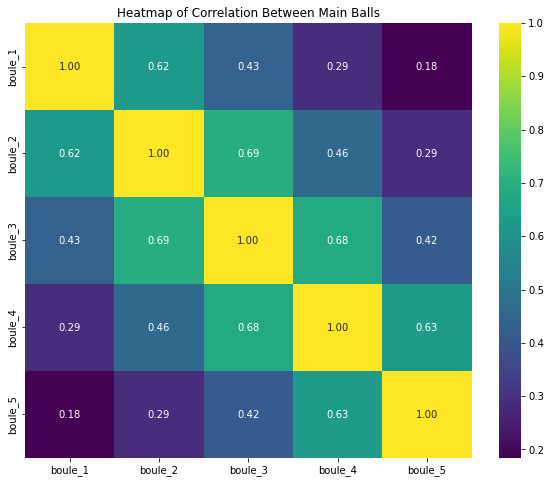

In [31]:
cross_tab = pd.crosstab(index=df['boule_1'], columns=[df['boule_2'], df['boule_3'], df['boule_4'], df['boule_5']])

# 计算五个主球之间的相关性矩阵
corr_matrix = df[['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5']].corr()

# 绘制热力图
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Heatmap of Correlation Between Main Balls')
plt.show()

#### 不同号码组合的共现频率

In [32]:
# 假设彩票主球号码范围是1到50
num_range = 50

# 创建一个矩阵来存储所有可能号码对的共现次数
co_occurrence_matrix = np.zeros((num_range, num_range))

# 计算共现次数
for index, row in df.iterrows():
    for i in range(1, 6):  # 只考虑主球号码
        for j in range(i+1, 6):
            num1, num2 = sorted([row[f'boule_{i}'], row[f'boule_{j}']])
            co_occurrence_matrix[num1-1, num2-1] += 1

# 由于矩阵是对称的，我们可以将其复制到下三角
for i in range(num_range):
    for j in range(i+1, num_range):
        co_occurrence_matrix[j, i] = co_occurrence_matrix[i, j]

# 生成悬停文本信息
hover_text = [['number1: {}, number2: {}, frequency: {}'.format(i+1, j+1, co_occurrence_matrix[i, j]) 
               for j in range(num_range)] for i in range(num_range)]

# 使用Plotly创建交互式热图
fig = go.Figure(data=go.Heatmap(
                   z=co_occurrence_matrix,  # 共现频率矩阵
                   x=[str(i) for i in range(1, num_range + 1)],  # 设置X轴范围为彩票号码的实际范围
                   y=[str(i) for i in range(1, num_range + 1)],  # 设置Y轴范围为彩票号码的实际范围
                   hoverongaps=False,  # 当鼠标悬停时不留白
                   colorscale='Viridis',  # 使用Viridis颜色映射
                   colorbar=dict(title='Co-occurrence Frequency'),  # 设置颜色条标题
                   text=hover_text,  # 设置悬停文本
                   hoverinfo='text'  # 指定只显示文本信息
               ))

fig.update_layout(
    title='Heatmap of Number Pair Co-occurrences',
    xaxis=dict(title='Number', tickmode='array', tickvals=list(range(1, num_range + 1))),
    yaxis=dict(title='Number', tickmode='array', tickvals=list(range(1, num_range + 1))),
    width=1000,  # 调整图表宽度
    height=800,  # 调整图表高度
)

fig.show()

#### 每年平均号码的变化趋势

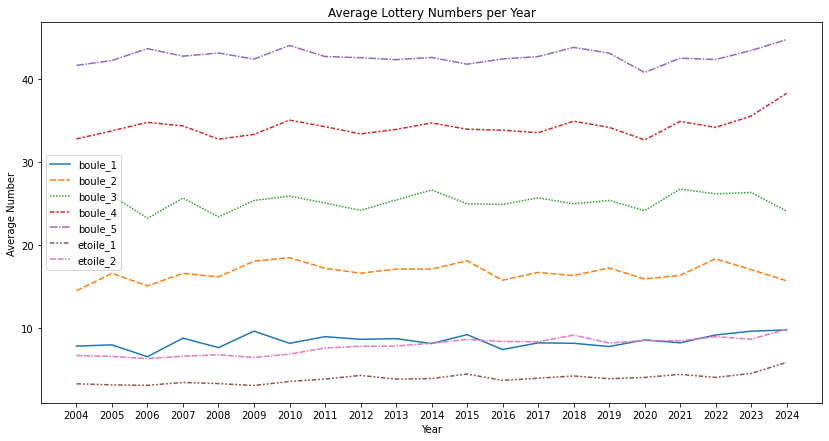

In [33]:
# 假设 'annee_numero_de_tirage' 是年份+编号的格式，先提取年份
df['year'] = df['annee_numero_de_tirage'].apply(lambda x: str(x)[:4])

# 计算每年的平均号码
average_numbers_per_year = df.groupby('year').mean()

# 绘制每年平均号码的变化趋势
plt.figure(figsize=(14, 7))
sns.lineplot(data=average_numbers_per_year[['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5', 'etoile_1', 'etoile_2']])
plt.title('Average Lottery Numbers per Year')
plt.ylabel('Average Number')
plt.xlabel('Year')
plt.show()


#### 每年最多出现号码的变化趋势

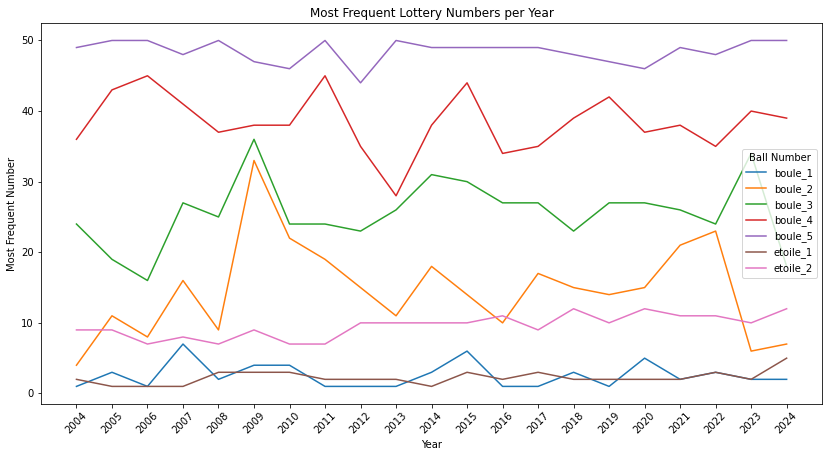

In [34]:
# 初始化存储每年最多出现号码的 DataFrame
most_frequent_numbers_per_year = pd.DataFrame()

# 对每个球号进行操作
for ball in ['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5', 'etoile_1', 'etoile_2']:
    # 初始化一个列表来存储每年最频繁的数字
    most_frequent_numbers = []
    
    # 对每个年份进行操作
    for year in df['year'].unique():
        # 筛选当前年份的数据
        year_df = df[df['year'] == year]
        
        # 计算当前年份当前球号的数字频率，并找到频率最高的数字
        most_frequent_number = year_df[ball].value_counts().idxmax()
        
        # 将最频繁的数字添加到列表中
        most_frequent_numbers.append(most_frequent_number)
    
    # 将每年最频繁的数字加入到 DataFrame 中
    most_frequent_numbers_per_year[ball] = most_frequent_numbers

# 设置年份为索引
most_frequent_numbers_per_year.index = df['year'].unique()

# 绘制每年最频繁出现的数字的变化趋势
plt.figure(figsize=(14, 7))
for ball in most_frequent_numbers_per_year.columns:
    sns.lineplot(data=most_frequent_numbers_per_year[ball], label=ball)
plt.title('Most Frequent Lottery Numbers per Year')
plt.ylabel('Most Frequent Number')
plt.xlabel('Year')
plt.legend(title='Ball Number')
plt.xticks(rotation=45)  # 旋转 x 轴标签以便更好地显示
plt.show()


# LSTM

#### 标准化 划分训练集 测试集

In [35]:
df = df.drop(['annee_numero_de_tirage','year'], axis=1)
df

,boule_1,boule_2,boule_3,boule_4,boule_5,etoile_1,etoile_2
0,16,29,32,36,41,7,9
1,7,13,39,47,50,2,5
2,14,18,19,31,37,4,5
3,4,7,33,37,39,1,5
4,15,24,28,44,47,4,5
...,...,...,...,...,...,...,...
1704,14,23,39,48,50,3,12
1705,8,19,32,41,42,9,12
1706,5,10,19,27,30,5,6
1707,13,20,23,27,42,5,9


In [36]:
#标准化
scaler = StandardScaler().fit(df.values)
transformed_dataset = scaler.transform(df.values)
transformed_df = pd.DataFrame(data=transformed_dataset, index=df.index)
print(transformed_df.head)

number_of_rows = df.values.shape[0]
window_length = 5
number_of_features = df.values.shape[1]

<bound method NDFrame.head of              0         1         2         3         4         5         6
0     1.135455  1.488528  0.771862  0.225763 -0.241146  1.196214  0.369545
1    -0.223222 -0.470669  1.578588  1.538514  1.110061 -0.790115 -1.195640
2     0.833527  0.141580 -0.726343 -0.370942 -0.841682  0.004417 -1.195640
3    -0.676114 -1.205367  0.887109  0.345104 -0.541414 -1.187381 -1.195640
4     0.984491  0.876279  0.310876  1.180491  0.659659  0.004417 -1.195640
...        ...       ...       ...       ...       ...       ...       ...
1704  0.833527  0.753829  1.578588  1.657855  1.110061 -0.392849  1.543433
1705 -0.072258  0.264030  0.771862  0.822468 -0.091012  1.990745  1.543433
1706 -0.525150 -0.838018 -0.726343 -0.848305 -1.892620  0.401682 -0.804344
1707  0.682563  0.386480 -0.265357 -0.848305 -0.091012  0.401682  0.369545
1708 -0.978043 -1.205367 -0.495850 -0.728964  0.359391  0.401682  1.152137

[1709 rows x 7 columns]>


In [37]:
# 划分训练集、测试集和验证集
train_size = int(number_of_rows * 0.8)
test_size = int((number_of_rows - train_size) * 0.5)  # 50% 划分给测试集，50% 划分给验证集

train_data, test_val_data = transformed_df.iloc[:train_size], transformed_df.iloc[train_size:]
test_data, val_data = train_test_split(test_val_data, test_size=test_size, shuffle=False)

# 构建训练集和标签集
train = np.empty([train_size - window_length, window_length, number_of_features], dtype=float)
label = np.empty([train_size - window_length, number_of_features], dtype=float)

for i in range(0, train_size - window_length):
    train[i] = train_data.iloc[i:i+window_length, 0:number_of_features]
    label[i] = train_data.iloc[i+window_length:i+window_length+1, 0:number_of_features]

# 构建测试集和标签集
test = np.empty([test_size - window_length, window_length, number_of_features], dtype=float)
test_label = np.empty([test_size - window_length, number_of_features], dtype=float)

for i in range(0, test_size - window_length):
    test[i] = test_data.iloc[i:i+window_length, 0:number_of_features]
    test_label[i] = test_data.iloc[i+window_length:i+window_length+1, 0:number_of_features]

# 构建验证集和标签集
val = np.empty([len(val_data) - window_length, window_length, number_of_features], dtype=float)
val_label = np.empty([len(val_data) - window_length, number_of_features], dtype=float)

for i in range(0, len(val_data) - window_length):
    val[i] = val_data.iloc[i:i+window_length, 0:number_of_features]
    val_label[i] = val_data.iloc[i+window_length:i+window_length+1, 0:number_of_features]


#### 建立模型

In [38]:
#模型
if os.path.exists('/Users/dantashashou/Downloads/euromillions/euromillions.h5'):
    model = load_model('/Users/dantashashou/Downloads/euromillions/euromillions.h5')
else:
    model = Sequential()
    model.add(LSTM(64, input_shape=(window_length, number_of_features), return_sequences=True))
    model.add(Dropout(0.2))
    # model.add(LSTM(64, return_sequences=True))
    # model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(number_of_features))

        
    #模型编译和训练
    model.compile(loss='mse', optimizer='rmsprop')
    history = model.fit(train, label, validation_data=(val, val_label), batch_size=64, epochs=120)

    # 保存模型
    # model.save('/Users/dantashashou/Downloads/euromillions/euromillions.h5')


Epoch 1/120
22/22 [==============================] - 5s 45ms/step - loss: 0.9882 - val_loss: 1.0610
Epoch 2/120
22/22 [==============================] - 0s 10ms/step - loss: 0.9829 - val_loss: 1.0640
Epoch 3/120
22/22 [==============================] - 0s 10ms/step - loss: 0.9818 - val_loss: 1.0652
Epoch 4/120
22/22 [==============================] - 0s 9ms/step - loss: 0.9806 - val_loss: 1.0654
Epoch 5/120
22/22 [==============================] - 0s 9ms/step - loss: 0.9794 - val_loss: 1.0703
Epoch 6/120
22/22 [==============================] - 0s 11ms/step - loss: 0.9791 - val_loss: 1.0735
Epoch 7/120
22/22 [==============================] - 0s 9ms/step - loss: 0.9785 - val_loss: 1.0746
Epoch 8/120
22/22 [==============================] - 0s 9ms/step - loss: 0.9779 - val_loss: 1.0811
Epoch 9/120
22/22 [==============================] - 0s 9ms/step - loss: 0.9785 - val_loss: 1.0741
Epoch 10/120
22/22 [==============================] - 0s 9ms/step - loss: 0.9760 - val_loss: 1.0811
Epoch

# 模型评估

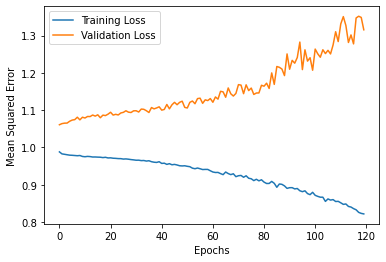

In [39]:
# 模型评估可视化
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [40]:
# 模型预测
scaled_predicted_output = model.predict(test)
predicted_output = scaler.inverse_transform(scaled_predicted_output).astype(int)
test_label_original = scaler.inverse_transform(test_label)

# 计算MSE
mse = mean_squared_error(test_label_original, predicted_output)

# 计算RMSE
rmse = np.sqrt(mse)

# 计算MAE
mae = mean_absolute_error(test_label_original, predicted_output)

# 计算R²
r2 = r2_score(test_label_original, predicted_output)

# 打印结果
print(f"均方误差（MSE）: {mse}")
print(f"均方根误差（RMSE）: {rmse}")
print(f"平均绝对误差（MAE）: {mae}")
print(f"决定系数（R²）: {r2}")

6/6 [==============================] - 1s 3ms/step
均方误差（MSE）: 51.175559380378665
均方根误差（RMSE）: 7.153709483923614
平均绝对误差（MAE）: 5.435456110154904
决定系数（R²）: -0.22069630482558153


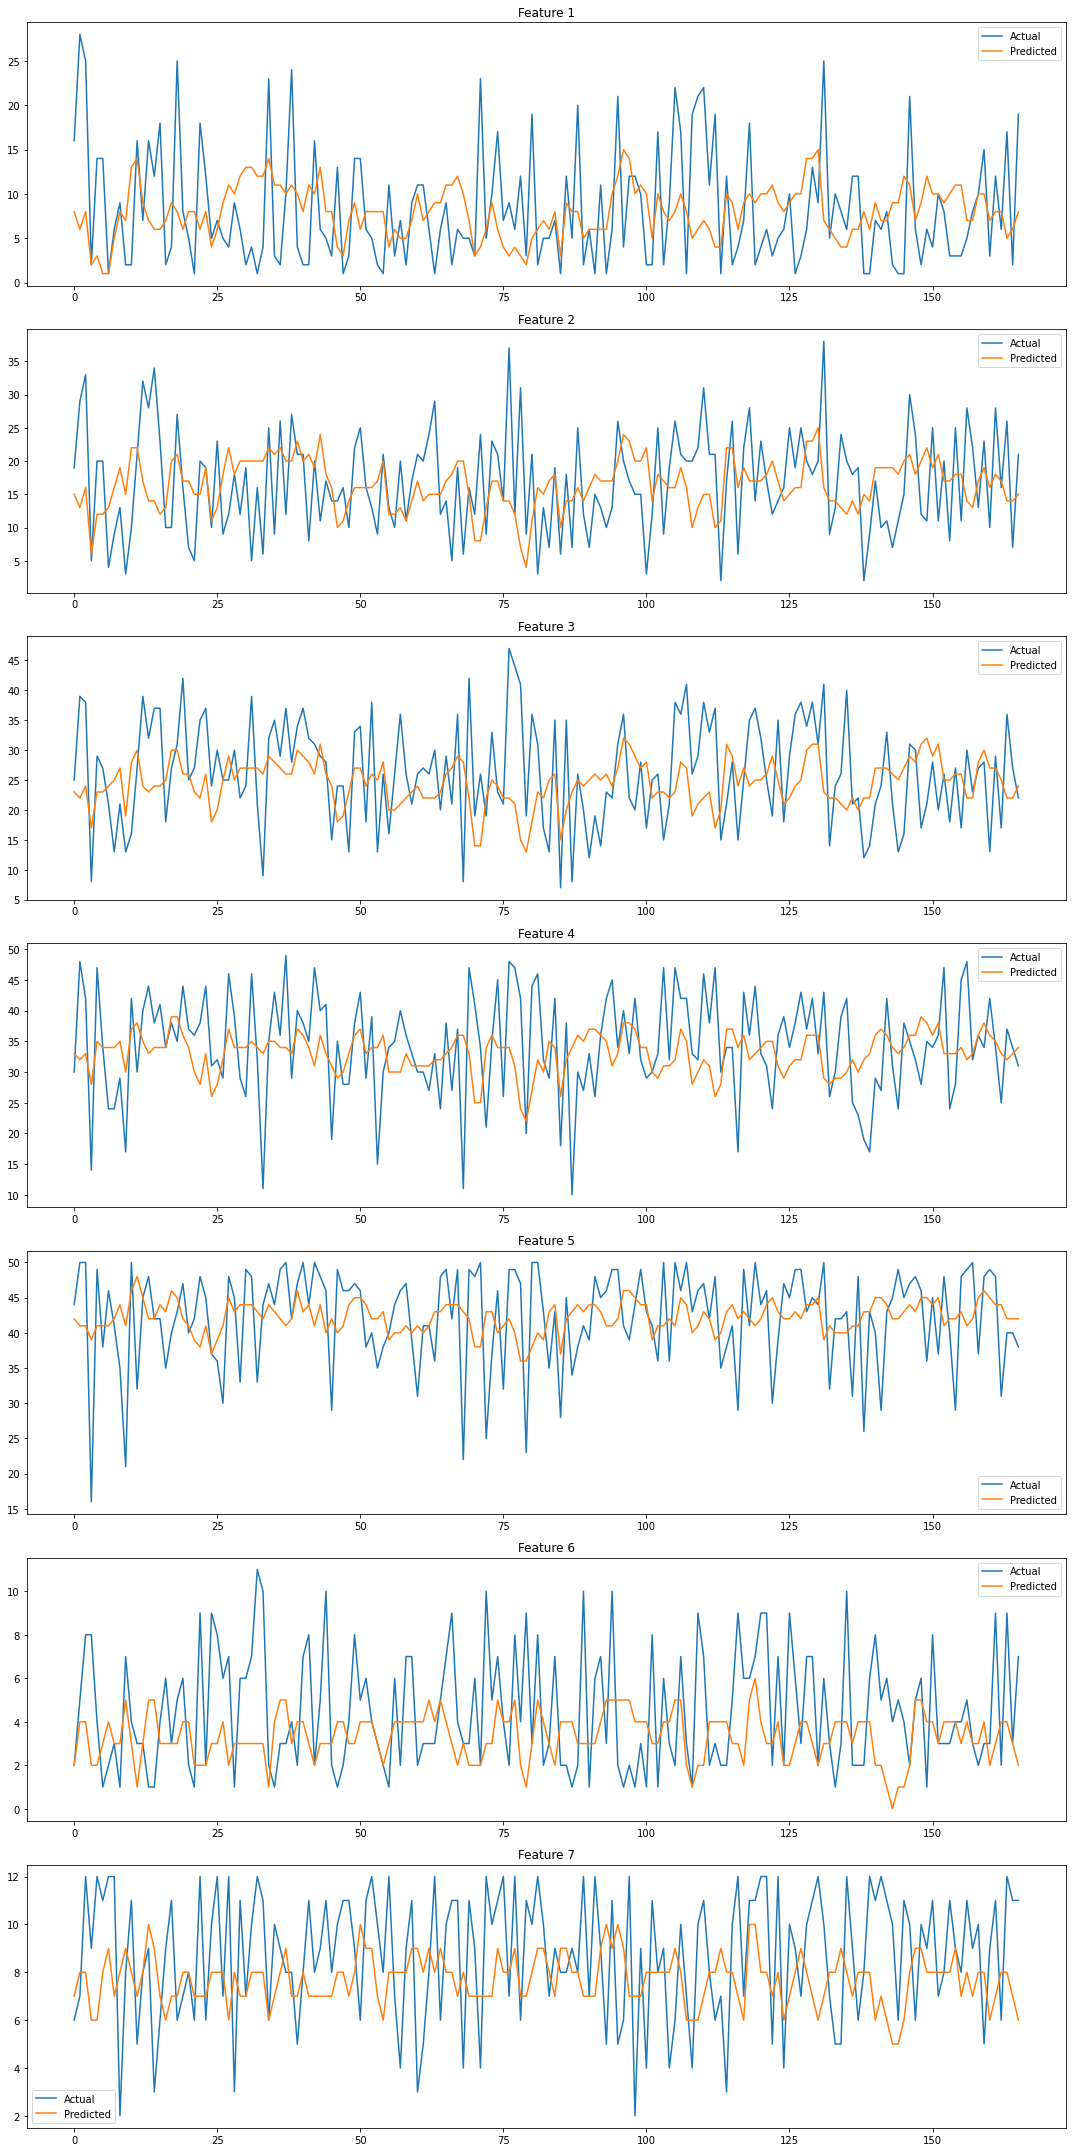

In [41]:
# 可视化预测结果
plt.figure(figsize=(15, 30))
for i in range(number_of_features):
    plt.subplot(7, 1, i+1)
    plt.plot(test_label_original[:, i], label='Actual')
    plt.plot(predicted_output[:, i], label='Predicted')
    plt.title(f'Feature {i+1}')
    plt.legend()

plt.tight_layout()
plt.show()


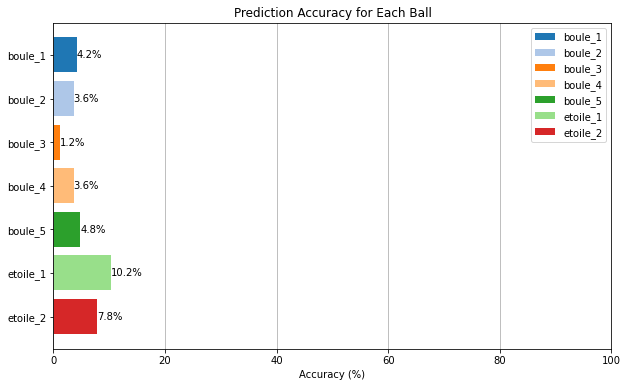

In [42]:
# 计算每个球的预测准确率
ball_names = ['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5', 'etoile_1', 'etoile_2']
accuracies = []
for i in range(number_of_features):
    correct_predictions = np.sum(test_label_original[:, i] == predicted_output[:, i])
    total_predictions = len(test_label_original[:, i])
    accuracy = correct_predictions / total_predictions * 100
    accuracies.append(accuracy)

# 绘制
plt.figure(figsize=(10, 6))
colors = plt.cm.tab20.colors
for i, (accuracy, color) in enumerate(zip(accuracies, colors)):
    plt.barh(i, accuracy, color=color, label=ball_names[i])
    plt.text(accuracy, i, f'{accuracy:.1f}%', va='center')
plt.xlim(0, 100)
plt.yticks(range(number_of_features), ball_names)
plt.xlabel('Accuracy (%)')
plt.title('Prediction Accuracy for Each Ball')
plt.grid(axis='x')
plt.legend()
plt.gca().invert_yaxis()  # 翻转y轴，使得球的顺序与输入的顺序一致
plt.show()

In [43]:
# 初始化计数器
winning_counts = {level: 0 for level in range(1, 14)}  # 从一等奖到十三等奖

# 定义中奖等级的判断逻辑
def check_winning_level(true, pred):
    main_ball_matches = len(set(true[:5]) & set(pred[:5]))
    star_matches = len(set(true[5:]) & set(pred[5:]))
    
    # 根据中奖规则判断等级
    if main_ball_matches == 5 and star_matches == 2:
        return 1
    if main_ball_matches == 5 and star_matches == 1:
        return 2
    if main_ball_matches == 5 and star_matches == 0:
        return 3
    if main_ball_matches == 4 and star_matches == 2:
        return 4
    if main_ball_matches == 4 and star_matches == 1:
        return 5
    if main_ball_matches == 3 and star_matches == 2:
        return 6
    if main_ball_matches == 4 and star_matches == 0:
        return 7
    if main_ball_matches == 2 and star_matches == 2:
        return 8
    if main_ball_matches == 3 and star_matches == 1:
        return 9
    if main_ball_matches == 3 and star_matches == 0:
        return 10
    if main_ball_matches == 1 and star_matches == 2:
        return 11
    if main_ball_matches == 2 and star_matches == 1:
        return 12
    if main_ball_matches == 2 and star_matches == 0:
        return 13
    return None

# 遍历每个预测和实际值，统计各等级的中奖次数
for true, pred in zip(test_label_original, predicted_output):
    winning_level = check_winning_level(true, pred)
    if winning_level:
        winning_counts[winning_level] += 1

# 计算总的预测次数
total_predictions = len(predicted_output)

# 计算每个等级的中奖率
winning_rates = {level: (count / total_predictions) * 100 for level, count in winning_counts.items()}

# 输出每个等级的中奖率
for level, rate in winning_rates.items():
    print(f"等级 {level} 中奖率: {rate:.2f}%")


等级 1 中奖率: 0.00%
等级 2 中奖率: 0.00%
等级 3 中奖率: 0.00%
等级 4 中奖率: 0.00%
等级 5 中奖率: 0.00%
等级 6 中奖率: 0.00%
等级 7 中奖率: 0.00%
等级 8 中奖率: 0.00%
等级 9 中奖率: 0.00%
等级 10 中奖率: 0.00%
等级 11 中奖率: 0.60%
等级 12 中奖率: 0.00%
等级 13 中奖率: 4.82%


# 预测结果

In [44]:
# 预测部分
to_predict = df.iloc[-5:]
scaled_to_predict = scaler.transform(to_predict)

scaled_predicted_output_1 = model.predict(np.array([scaled_to_predict]))
data = scaler.inverse_transform(scaled_predicted_output_1).astype(int)
predict = pd.DataFrame(data, columns=['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5', 'etoile_1', 'etoile_2'])

predict

1/1 [==============================] - 0s 26ms/step


,boule_1,boule_2,boule_3,boule_4,boule_5,etoile_1,etoile_2
0,7,16,24,33,42,3,8
